#  MEPS With an Inductive Bias in the Computer Maintenance Environment

**Philip A. LeMaitre, Marius Krumm**

In this notebook, we will train Multi-Excitation Projective Simulation (MEPS) agents with an inductive bias on another a more intricate synthetic environment with more complexity than both of the **Invasion Game With Distraction** and the **Deceptive Invasion Game**. We call this new environment **Computer Maintenance**. 

In this reinforcement learning environment, the observations that the agent receives are comprised of varying numbers of possible symptoms that are indicative of an underlying problem that is specified by a scenario defined in the initialization of the environment. The agent we consider here is a three-layer agent whose hidden intermediate layer represents what they think the cause of the underlying problem is and in which components it is. The actions that can be taken by the agent, for a given choice of cause (determined internally), are a choice of which computer components they think are part of the problem and a choice of possible fixes they can enact to deal with the problem. Each category is represented by a dictionary that indexes these statements into an integer. What the agent sends to the environment to get a reward is their internal deliberation chain, which is like an explanation to a customer of what the problem is and how the agent fixed it. The agent's explanation is then compared to the initially generated scenario and also checked against plausible cause-action pairs to determine a reward.

The point of this more nuanced environment, is to test the MEPS agent for complex scenarios that require the agent to combine multiple concepts together in order to solve a problem that couldnt otherwise be solved by only considering one excitation at a time. This environment also represents an interesting and practical real-world task.

In [38]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import chain, product, combinations
import torch
import seaborn as sns
import os
import sys

np.set_printoptions(edgeitems=300, threshold=20000, linewidth=150)

print("Python version:", sys.version)
print("Pytorch version:", torch.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

Python version: 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)]
Pytorch version: 2.1.2
Numpy version: 1.26.3
Matplotlib version: 3.8.2
Seaborn version: 0.13.1


In [41]:
def reward_func(reward, it, max_t):
    """
    Modifies the reward given by the environment.

    Parameters
    ----------
    reward : float
        The reward given by the environment.
    it : int
        The iteration number of the training loop.
    max_t : int
        The maximum number of iterations allowed before a penalty is applied.

    Returns
    -------
    new_reward : float
        The modified reward.
    """
    new_reward = np.array(reward)

    if it >= max_t:
        new_reward -= 0.25*np.log(it-max_t+1)
    
    return np.clip(new_reward, -16, None)
    

class BrokenComputerEnv():
    """
    The Computer Maintenance environment.
    """
    def __init__(self, seed):

        # Possible symptoms of the underlying issues
        self.symptoms = {
                         'PC overheating': 1, 
                         'files disappearing': 2, 
                         'visible markings on components': 3,
                         'unexpected shutdowns': 4,
                         'slow performance': 5,
                         'old hardware': 6,
                         'strange noises': 7,
                         'software glitches': 8,
                         #'blue screen': 9,
                         #'no internet': 10
                        }
        
        # Possible actions the agent can take
        act_start = list(self.symptoms.values())[-1]
        self.actions = {
                        'replace components': act_start+1, 
                        'install missing software': act_start+2, 
                        'cooldown computer': act_start+3,
                        'run antivirus': act_start+4,
                        #'check network settings': act_start+5,
                        #'run diagnostics': act_start+6,
                        #'reboot': act_start+7,
                        #'connect components': act_start+8,
                        #'benchmark components': act_start+9
                       }

        # Possible components the agent can select
        comp_start = list(self.actions.values())[-1]
        self.components = {
                           'CPU': comp_start+1,
                           'SSD': comp_start+2, 
                           'MoBo': comp_start+3,
                           'PSU': comp_start+4,
                           'OS': comp_start+5,
                           #'GPU': comp_start+6,
                           #'Fans': comp_start+7,
                           #'CPU cooler': comp_start+8,
                           #'RAM': comp_start+9,
                           #'BIOS': comp_start+10
                          }

        # Possible causes the agent can select
        cause_start = list(self.components.values())[-1]
        self.causes = {
                       'physical damage': cause_start+1,
                       'software damage': cause_start+2,
                       'malware': cause_start+3,
                       'faulty': cause_start+4,
                       'not connected': cause_start+5,
                       #'not compatible': cause_start+6,
                       #'not initialized': cause_start+7,
                       #'overworked': cause_start+8,
                       #'overheat': cause_start+9,
                       #'corrupt files': cause_start+10,
                       #'system error': cause_start+11
                      }
        
        # Possible scenarios
        self.scenarios = [
                          [[self.symptoms['files disappearing'], self.symptoms['visible markings on components']],
                           [self.components['SSD'], self.components['MoBo']],
                           [self.causes['physical damage'], self.causes['software damage']],
                           [self.actions['replace components']]],
                          [[self.symptoms['PC overheating'], self.symptoms['visible markings on components']],
                           [self.components['CPU'], self.components['MoBo']],
                           [self.causes['physical damage'], self.causes['software damage']],
                           [self.actions['replace components'], self.actions['cooldown computer']]],
                          [[self.symptoms['visible markings on components'], self.symptoms['unexpected shutdowns']],
                           [self.components['MoBo'], self.components['PSU']],
                           [self.causes['physical damage'], self.causes['software damage']],
                           [self.actions['replace components']]],
                          [[self.symptoms['unexpected shutdowns'], self.symptoms['slow performance']],
                           [self.components['CPU'], self.components['PSU']],
                           [self.causes['physical damage'], self.causes['software damage']],
                           [self.actions['replace components']]],
                          #[[self.symptoms['slow performance'], self.symptoms['old hardware']],
                           #[self.components['GPU']],
                           #[self.causes['faulty']],
                           #[self.actions['replace components']]],
                          #[[self.symptoms['slow performance'], self.symptoms['strange noises']],
                           #[self.components['Fans']],
                           #[self.causes['faulty']],
                           #[self.actions['replace components']]],
                          #[[self.symptoms['slow performance'], self.symptoms['software glitches']],
                           #[self.components['GPU']],
                           #[self.causes['software damage']],
                           #[self.actions['install missing software']]],
                          [[self.symptoms['files disappearing'], self.symptoms['old hardware']],
                           [self.components['SSD']],
                           [self.causes['faulty']],
                           [self.actions['replace components']]],
                          [[self.symptoms['unexpected shutdowns'], self.symptoms['old hardware']],
                           [self.components['CPU']],
                           [self.causes['faulty']],
                           [self.actions['replace components']]],
                          [[self.symptoms['files disappearing'], self.symptoms['strange noises']],
                           [self.components['SSD']],
                           [self.causes['faulty']],
                           [self.actions['replace components']]],
                          #[[self.symptoms['PC overheating'], self.symptoms['strange noises']],
                           #[self.components['Fans']],
                           #[self.causes['faulty']],
                           #[self.actions['replace components']]],
                          [[self.symptoms['unexpected shutdowns'], self.symptoms['software glitches']],
                           [self.components['CPU']],
                           [self.causes['software damage']],
                           [self.actions['install missing software']]],
                          [[self.symptoms['files disappearing'], self.symptoms['unexpected shutdowns']],
                           [self.components['OS']],
                           [self.causes['malware']],
                           [self.actions['run antivirus']]],
                          [[self.symptoms['files disappearing'], self.symptoms['software glitches']],
                           [self.components['OS']],
                           [self.causes['software damage'], self.causes['malware']],
                           [self.actions['install missing software'], self.actions['run antivirus']]],
                          [[self.symptoms['PC overheating'], self.symptoms['software glitches']],
                           [self.components['CPU'], self.components['OS']],
                           [self.causes['software damage']],
                           [self.actions['install missing software'], self.actions['cooldown computer']]],
                         ]
        
        # Random generator
        self.rng = np.random.default_rng(seed)
        
        
    def verify_scenario(self, expln):
        """
        Checks whether the explanation given by the agent agrees with that specified by the given scenario.
        """
        # Explanation corresponding to action layer
        temp_scenario_act = [expln[0][0], expln[-1][0], expln[-1][1]]
        tot_len_act = len(temp_scenario_act)
        temp_scenario_act_len = [len(temp_scenario_act[i]) for i in range(tot_len_act)]
        act_ind = [0, 1, 3]
        act_scenario_state_len = [len(self.scenario_state[i]) for i in act_ind]
        # Explanation corresponding to hidden layer
        temp_scenario_perc = [expln[0][0], expln[1][0], expln[1][1]]
        tot_len_perc = len(temp_scenario_perc)
        temp_scenario_perc_len = [len(temp_scenario_perc[i]) for i in range(tot_len_perc)]
        perc_scenario_state_len = [len(self.scenario_state[i]) for i in range(tot_len_perc)]
        # Compute the sum of how many elements in each category agree between the scenario constructed from the
        # agent's choices and the chosen scenario at initialization, for action and hidden layers, respectively
        act_scenario_ind = [sum([np.any(temp_scenario_act[i][j] == np.copy(self.scenario_state[act_ind[i]])) for j in range(temp_scenario_act_len[i])]) for i in range(tot_len_act)]
        perc_scenario_ind = [sum([np.any(temp_scenario_perc[i][j] == np.copy(self.scenario_state[i])) for j in range(temp_scenario_perc_len[i])]) for i in range(tot_len_perc)]
        # Check whether the scenario constructed from the agent's choices at least contains the scenario at initialization,
        # for action and hidden layers, respectively
        temp_if_act = [True if ((act_scenario_ind[i] == act_scenario_state_len[i]) and (temp_scenario_act_len[i] == act_scenario_state_len[i])) else False for i in range(tot_len_act)]
        temp_if_perc = [True if ((perc_scenario_ind[i] == perc_scenario_state_len[i]) and (temp_scenario_perc_len[i] == perc_scenario_state_len[i])) else False for i in range(tot_len_perc)]
        
        # Because the percepts are coupled in exactly, the percept in the agent's explanation will always match the one in scenario_state. Therefore,
        # we do not need to include it when verifying that the agent got the right scenario (for now).
        
        tot_vec = [False, False, False]
        # Check if all categories in action layer explanation except the first fulfill the condition for temp_if_act
        if (sum(temp_if_act[1:]) == 2):
            tot_vec[1] = True

        # Check if all categories in hidden layer explanation except the first fulfill the condition for temp_if_perc
        if (sum(temp_if_perc[1:]) == 2):
            tot_vec[0] = True

        # Check if all categories in both the hidden and action layer explanations match those in scenario_state
        if tot_vec[0] and tot_vec[1]:
            tot_vec[2] = True
        
        return tot_vec
        
    
    def reset(self):
        """
        Resets the environment, generating a new scenario and symptoms.
        """
        
        # The following section is written in a way such that the symptom subsets can have more symptoms than a scenario in scenarios has, which allows
        # for irrelevant symptoms to be included if desired.

        # Generate initial scenario
        self.scenario_state = self.scenarios[self.rng.choice(len(self.scenarios))]
        # Construct symptom sets containing the symptom set from the chosen scenario
        self.sym_subsets = [self.scenario_state[0]]
        # Randomly select one of the symptom sets
        self.sym_set = self.sym_subsets[self.rng.choice(len(self.sym_subsets))]
        # Generate initial symptoms 
        self.state = self.sym_set
        
        return self.state

    
    def step(self, expln):
        """
        Given an action input and explanation list, return the current state and a reward, along with
        a signal indicating whether the problem has been solved.
        """
        reward = [0, 0]
        done = False

        # Part of the agent's explanation to the customer is used to verify if the problem is solved and get a reward.
        expl_vec = expln[1]
        # Penalties for choosing too many and too few elements from each category except the symptoms, respectively
        penalty = np.array([1.0, 0.2])
        # Conditions for triggering the penalties.
        # Check the difference in length between each part of the agent's explanation and the initially generated scenario
        pen_cond = np.array([(len(expl_vec[i]) - len(self.scenario_state[i+1])) for i in range(len(expl_vec))])
        # Normalize the above. 0 indicates they are the same length, so no penalty. 1 indicates that the agent's explanation contains more elements
        # than the initially generated scenario per category, which then activates the penalty for too many elements. -1 indicates that the agent's
        # explanation contains less elements than the initially generated scenario per category, which then activates the penalty for too few elements. 
        norm_pen_cond = np.array([pen_cond[i]/abs(pen_cond[i]) if pen_cond[i] != 0 else 0 for i in range(len(pen_cond))])
        # np.maximum will not apply the penalty for too many elements if that element of norm_pen_cond is not 1, and the normalized sum converts everything
        # to a scalar.
        reward[0] -= np.sum(np.maximum(norm_pen_cond, np.zeros(len(norm_pen_cond))))*penalty[0]/len(norm_pen_cond)
        
        # The plausibility reward. This reward assesses how well the agent's chosen fixes reflect the causes that it identified, as well as
        # if the components associated with chosen causes are the same as those associated with chosen fixes.
        plaus_max_reward = [1.0, 0.3]
        plaus_penalty = [2.0, 2.0, 4.0]

        # Evaluates how many of the components in the chosen action layer clip are also in the chosen hidden layer clip
        val = sum([int(np.any(expln[2][0][i] == np.copy(expln[1][0]))) for i in range(len(expln[2][0]))])
        
        # Get a reward if all components in the chosen action layer clip are in the chosen hidden layer clip and they are the same size
        if (val == len(expln[2][0])) and (len(expln[2][0]) == len(expln[1][0])):
            reward[1] += plaus_max_reward[0]
        # Get a smaller reward if only all components in the chosen action layer clip are in the hidden layer clip
        elif (val == len(expln[2][0])):
            reward[1] += plaus_max_reward[0]/4
        # Receive a punishment otherwise
        else:
            reward[1] -= plaus_penalty[0]
        
        # The agent is rewarded for associating certain causes with certain fixes, and punished otherwise
        plaus_reward_divisor = len(self.scenario_state[-1]) # might be better to have this depend on agents chosen fixes so it encourages smaller length fixes
        conds = [np.any(expln[1][1] == np.copy(self.causes['physical damage'])), np.any(expln[1][1] == np.copy(self.causes['software damage'])),
                 np.any(expln[1][1] == np.copy(self.causes['malware'])), np.any(expln[1][1] == np.copy(self.causes['faulty']))]
        
        if np.any(expln[2][1] == np.copy(self.actions['replace components'])):
            if (conds[0] or conds[3]):
                reward[1] += plaus_max_reward[1]/plaus_reward_divisor
            else:
                reward[1] -= plaus_penalty[1]/plaus_reward_divisor

            if ((conds[1] or conds[2]) and not (conds[0] or conds[3])):
                reward[1] -= plaus_penalty[1]/plaus_reward_divisor
            
        if np.any(expln[2][1] == np.copy(self.actions['install missing software'])):
            if conds[1]:
                reward[1] += plaus_max_reward[1]/plaus_reward_divisor
            else:
                reward[1] -= plaus_penalty[1]/plaus_reward_divisor

            if ((conds[0] or conds[3]) and not (conds[1] or conds[2])):
                reward[1] -= plaus_penalty[1]/plaus_reward_divisor
            
        if np.any(expln[2][1] == np.copy(self.actions['run antivirus'])):
            if conds[2]:
                reward[1] += plaus_max_reward[1]/plaus_reward_divisor
            else:
                reward[1] -= plaus_penalty[1]/plaus_reward_divisor

            if ((conds[0] or conds[3]) and not (conds[1] or conds[2])):
                reward[1] -= plaus_penalty[1]/plaus_reward_divisor

        if np.any(expln[2][1] == np.copy(self.actions['cooldown computer'])):
            if conds[1]:
                reward[1] += plaus_max_reward[1]/plaus_reward_divisor
            #else:
            #    reward[1] -= plaus_penalty[1]/plaus_reward_divisor
        
        # Penalty on the plausibility reward to discourage choosing too many components/causes; same comments as for the previous penalty for
        # too many components/fixes.
        plaus_expl_vec = expln[-1]
        plaus_ind = [1, 3]
        plaus_pen_cond = np.array([(len(plaus_expl_vec[i]) - len(self.scenario_state[plaus_ind[i]])) for i in range(len(plaus_expl_vec))])
        plaus_norm_pen_cond = np.array([plaus_pen_cond[i]/abs(plaus_pen_cond[i]) if plaus_pen_cond[i] != 0 else 0 for i in range(len(plaus_pen_cond))])
        reward[1] -= np.sum(np.maximum(plaus_norm_pen_cond, np.zeros(len(plaus_norm_pen_cond))))*plaus_penalty[2]/len(plaus_norm_pen_cond)
            
        # Check whether the agent solved the problem
        tot_vec = self.verify_scenario(expln)
            
        # Give a partial reward bonus to the agent if their chosen hidden layer clip matches the scenario and severely punish otherwise
        if tot_vec[0]:
            reward[0] += 5
        else:
            reward[0] -= 10
        
        # Give a partial reward bonus to the agent if their chosen action layer clip matches the scenario and severely punish otherwise
        if tot_vec[1]:
            reward[1] += 5
        else:
            reward[1] -= 10
            
        # Give a large reward bonus to the agent for having the scenario as their explanation, making the deliberation path clearer
        if tot_vec[2]:
            reward[0] += 15
            reward[1] += 15
            # Signal to end episode
            done = True

        # This represents the destruction of the computer, which results in a severe punishment for the agent and ends the episode
        #if np.any(expln[2][1] == np.copy(self.actions['benchmark components'])) and np.any(expln[0][0] == np.copy(self.symptoms['PC overheating'])):
        #    reward[0] -= 15
        #    reward[1] -= 15
        #    done = True
        
        return self.state, reward, done

Now define the PS agent.

In [42]:
class PSAgent():
    
    def __init__(self, pca, gamma_damping, eta_glow_damping, seed, beta_softmax, num_layers, n_body):
        """
        Base class of a Reinforcement Learning agent based on Multi-Excitation Projective Simulation,
        with three-layered network.

        Parameters
        ----------
        pca : list
            The possible percepts/clips/actions that the agent can receive/have/take.
        gamma_damping : float (between 0 and 1)
            Forgetting/damping of h-values at the end of each interaction.
        eta_glow_damping : float (between 0 and 1)
            Controls the damping of glow; setting this to 1 effectively switches off glow.
        seed : int
            Seed for random number generator. 
        beta_softmax : float >=0
            Probabilities are proportional to exp(beta*h_value). If policy_type != 'softmax', then this is irrelevant.
        num_layers : int
            The number of transitions between layers during deliberation.
        n_body : list
            A list of the many-body cutoff for source and target hyperedges.
        """
        
        self.n_body = n_body
        self.num_layers = num_layers
        self.pca = pca
        self.gamma_damping = gamma_damping
        self.eta_glow_damping = eta_glow_damping
        self.beta_softmax = beta_softmax

        # Random generator
        self.rng = np.random.default_rng(seed)

        # Generate all percept hyperedges of length n_body[0][0][j] for each element in n_body[0][0] at initialization.
        # If the percept hyperedges are tuples, then do the above separately for each element of the tuple and then take the Cartesian product of all elements.
        percept_hyedge = [
                          list(chain.from_iterable(
                                                   [[list(x) for x in combinations(self.pca[0][j], k+1)] for k in range(self.n_body[0][0][j])]
                                                  ))
                          for j in range(len(self.pca[0]))
                         ]
        percept_hyedge = [list(x) for x in product(*percept_hyedge)]
        
        # Generate all action hyperedges of length up to n_body[-1][1][j] for each element in n_body[-1][1] at initialization.
        # If the action hyperedges are tuples, then do the above separately for each element of the tuple and then take the Cartesian product of all elements.
        act_hyedge = [
                      list(chain.from_iterable(
                                               [[list(x) for x in combinations(self.pca[-1][j], k+1)] for k in range(self.n_body[-1][1][j])]
                                              ))
                      for j in range(len(self.pca[-1]))
                     ]
        act_hyedge = [list(x) for x in product(*act_hyedge)]
        # problem is that scenarios have different lengths, so only one many-body cutoff value will not let the agent learn properly; need to have all orders below a specific value

        # Generate all clip hyperedges of length n_body[0][1] or n_body[1][0] (they have to be the same anyways)
        clip_hyedges = [
                        [list(x) for x in product(*
                                [
                                    list(chain.from_iterable(
                                    [[list(x) for x in combinations(self.pca[k][j], m+1)] for m in range(self.n_body[0][1][j])]
                                    )) 
                                    for j in range(len(self.pca[k]))
                                ]
                                                 )]
                        for k in range(1, self.num_layers)
                       ]
        self.clips_set = [[percept_hyedge, clip_hyedges[0]]] + [[clip_hyedges[-1], act_hyedge]]

        # Compute the Cartesian product of clips_set
        clip_configs = [list(product(*self.clips_set[i])) for i in range(self.num_layers)]

        # Initialize the many-body h and glow arrays to all 1's and 0's, respectively. An array for each transition between layers is generated as a 1-D numpy
        # structured array where each element is a tuple consisting of a nested list with 'object' data type, and a number with 'float64' data type.
        self.h_matrix = [np.array([(clip_configs[i][j], 1) for j in range(len(clip_configs[i]))], dtype='object, f8') for i in range(self.num_layers)]
        self.g_matrix = [np.array([(clip_configs[i][j], 0) for j in range(len(clip_configs[i]))], dtype='object, f8') for i in range(self.num_layers)]
        
        # Save a copy of the h and glow array initializations for the learning update and the glow reset function.
        self.h_0 = [np.copy(self.h_matrix[i]) for i in range(self.num_layers)]
        self.g_0 = [np.copy(self.g_matrix[i]) for i in range(self.num_layers)]

    
    def deliberate(self, percept, it, last_perc_vals):
        """
        Given a percept, this method chooses the next action and records that choice in the glow arrays.

        Parameters
        ----------
        percept : list
            List that describes the observation.

        Returns
        -------
        clips : list
            The chosen percepts/clips/actions during deliberation.
        actions : list
            The chosen action target hyperedge.
        """
        # Generate all subsets of percept of length n_body[0][0][j] for each element in n_body[0][0] once at the beginning of the episode, then reuse this list for the remainder.
        # If percept is a tuple, then do the above separately for each element of the tuple and then take the Cartesian product of all elements.
        if it == 0:
            perc_vals = [
                        list(chain.from_iterable(
                            [[list(x) for x in combinations(percept, m+1)] for m in range(self.n_body[0][0][j])]
                        )) 
                        for j in range(len(self.n_body[0][0]))
                        ]
            perc_vals = [list(x) for x in product(*perc_vals)]
        else:
            perc_vals = last_perc_vals
        
        # The agent's explanation 
        clips = []
        # The random walk through the ECM
        for n in range(self.num_layers):
            # For the special case of the input percept
            if n == 0:
                # Find the entries of the h array that match those in percepts
                rel_trans = [item for item in self.h_matrix[0] if item[0][0] in perc_vals]
                # Create a probability list from the previous h values using a softmax function
                probs = torch.softmax(self.beta_softmax[0]*torch.tensor([a[1] for a in rel_trans]), dim = 0).numpy()
                # Randomly choose one of the possible transitions according to probs and extract the index of the transition from the h array
                chosen_trans_ind = self.rng.choice(len(rel_trans), p=probs)
                # Convert that index into the actual corresponding hyperedge 
                chosen_trans = rel_trans[chosen_trans_ind]

                # Record the percept hyperedge in the clips list
                clips.append(chosen_trans[0][0])
            # For the rest of the clips but using the chosen hidden layer clip as a starting point
            else:
                # Generate all subsets of the chosen clip of length up to n_body[n][0][j] for each element in n_body[n][0] for the total number of transitions between layers (n=0,...,num_layers-1).
                # If the clip is a tuple, then do the above separately for each element of the tuple and then take the Cartesian product of all elements.
                input_trans_list = [
                                    list(chain.from_iterable(
                                        [[list(x) for x in combinations(clips[-1][j], m+1)] for m in range(self.n_body[n][0][j])]
                                    )) 
                                    for j in range(len(self.n_body[n][0]))
                                   ]
                input_trans_list = [list(x) for x in product(*input_trans_list)]
                rel_trans1 = [item for item in self.h_matrix[n] if item[0][0] in input_trans_list]
                probs1 = torch.softmax(self.beta_softmax[n]*torch.tensor([a[1] for a in rel_trans1]), dim = 0).numpy()
                chosen_trans_ind1 = self.rng.choice(len(rel_trans1), p=probs1)
                chosen_trans = rel_trans1[chosen_trans_ind1]
                
            # Record the target hyperedge in the clips list
            clips.append(chosen_trans[0][1])
                
            # Update and record the latest decision in the glow array
            self.g_matrix[n]['f1'] = (1.0-self.eta_glow_damping[n])*self.g_matrix[n]['f1']
            self.g_matrix[n]['f1'][self.g_matrix[n]['f0'].tolist().index(chosen_trans[0])] += 1.0   
            
        # Return the percepts list to be reused and the agent's explanation
        return perc_vals, clips
        
        
    def learn(self, reward):
        """
        Given a reward, this method updates the h array.

        Parameters
        ----------
        reward : float
            Value of the obtained reward.
        """
        # The action reward is applied to the first h array while the plausibility reward is applied to the second h array.
        reward_vec = [reward[0], reward[1]]
        for i in range(self.num_layers):
            self.h_matrix[i]['f1'] = self.h_matrix[i]['f1'] - self.gamma_damping[i] * (self.h_matrix[i]['f1'] - self.h_0[i]['f1']) + reward_vec[i] * self.g_matrix[i]['f1']
            
    
    def reset_g(self):
        """
        Resets the glow array.
        """
        self.g_matrix = [np.copy(self.g_0[i]) for i in range(self.num_layers)]


And then we can define the training loop:

In [43]:
def train(env, agent, num_episodes, max_time, max_iter, num, func):
    
    # Initialization of learning curve quantities
    hypo_rewards_all_episodes = []
    plaus_rewards_all_episodes = []
    stepnum_to_success = []

    # tqdm shows the iteration progress as well as how long it is estimated to take and the iteration speed
    for e in tqdm(range(num_episodes)):
        
        # Restart environment, agent's counter, glow matrix, learning curve quantities, and episode end signal
        agent.reset_g()
        state = env.reset()
        done = False
        rewards_current_episode = np.array([0, 0])
        iter = 0
        perc_vals1 = 0
    
        while not done:
            
            perc_vals, hyclips = agent.deliberate(state, iter, perc_vals1) # Decide
            perc_vals1 = perc_vals
            next_state, reward, done = env.step(hyclips) # Act
            new_reward = func(reward, iter, max_time)
            agent.learn(new_reward) # Learn
            
            rewards_current_episode = rewards_current_episode + new_reward
            state = next_state
            iter += 1

            # A conditional to prevent the agent from taking too many steps in an episode
            if iter > max_iter:
                break

        if (e+1) % 500 == 0:
            # Save h matrices of the agent at this stage of the learning process
            np.savez('./MEPS_Data/h_memory_inductivebias_agent{a0}_{a1}_episode_{a2}_{a3}.npz'
                     .format(a0=num[0], a1=num[1], a2=e+1, a3="BrokenComputer"), h_mat1=agent.h_matrix[0], h_mat2=agent.h_matrix[1])

        hypo_rewards_all_episodes.append(rewards_current_episode[0])
        plaus_rewards_all_episodes.append(rewards_current_episode[1])
        stepnum_to_success.append(iter)

    print("Scenario: {a0}".format(a0=env.scenario_state[1:]))
    print("Final Explanation: {a0}".format(a0=hyclips[1:]))

    return hypo_rewards_all_episodes, plaus_rewards_all_episodes, stepnum_to_success

Next, we define the training loop parameters. The hyperparameters of the agent are listed in the third block for each possible agent in n_body_agent and the training duration parameters in the first. Each category of symbol is initialized to zero and will be filled at the beginning of the training loop in the next cell. The last block contains the quantities that the learning curves will be constructed from. To get an impression for how sensitive the learning is with respect to the random number generation used during sampling, we average over several agents with different seed values given in the lists in the fourth block, using the same parameters .

In [44]:
# Each element in the outer list represents a transition between layers and within those elements, there are two elements:
# the many-body cutoff for the source layer and the target layer, respectively. If the elements in a layer are actually
# tuples, then there will be a many-body cutoff for each element in the tuple.
nbody_agent = [
                [[[2], [2, 2]], [[2, 2], [2, 2]]]
              ]
num_agents = len(nbody_agent)
num_layers = [2]
episodes = [1000]
max_time = 500
max_iter = [1000]

pca = 0

# The number of elements in the outer list should match the number of agents specified by num_agents, and within each element
# there are two values: one for the source layer and the other for the target layer.
gamma = [[0.0, 0.0]]
eta_glow = [[1.0, 1.0]]
beta = [[0.5, 0.5]]

size = 100
seeds = np.random.choice(np.arange(1, 10**3), size=size, replace=False)
env_seed_list = seeds[:int(size/2)]
agent_seed_list = seeds[int(size/2):]

average_hypo_reward_list_all = [[] for i in range(num_agents)]
average_plaus_reward_list_all = [[] for i in range(num_agents)]
stepnum_list_all = [[] for i in range(num_agents)]
hypo_means = []
hypo_stds = []
plaus_means = []
plaus_stds = []
stepnum_means = []
stepnum_stds = []

Now for the actual training and construction of the learning curve quantities. The environments and agents are generated once per seed value and then discarded after saving the learning curve quantities to external lists.

In [45]:
try:
    os.mkdir('./MEPS_Data')
except OSError as error:
    print("Directory ./MEPS_data exists, overwriting content")

for i in range(num_agents):
    for ind in range(len(agent_seed_list)):
        env = BrokenComputerEnv(env_seed_list[ind])
        if i == 0:
            actions = list(env.actions.values())
            components = list(env.components.values())
            causes = list(env.causes.values())
            full_init_clips = [components, causes]
            full_init_actions = [components, actions]
            percepts = [list(env.symptoms.values())]
            pca = [percepts, full_init_clips, full_init_actions]
        
        agent = PSAgent(pca=pca, n_body=nbody_agent[i], seed=agent_seed_list[ind], beta_softmax=beta[i], gamma_damping=gamma[i],
                        eta_glow_damping=eta_glow[i], num_layers=num_layers[i])
        average_hypo_reward_list, average_plaus_reward_list, stepnum_list = train(env, agent, episodes[i], max_time, max_iter[i], [i+1, ind+1], reward_func)
        average_hypo_reward_list_all[i].append(average_hypo_reward_list)
        average_plaus_reward_list_all[i].append(average_plaus_reward_list)
        stepnum_list_all[i].append(stepnum_list)
        
    # Used for representation of fluctuations in learning curves
    stepnum_list_all[i] = np.array(stepnum_list_all[i])
    average_hypo_reward_list_all[i] = np.array(average_hypo_reward_list_all[i])/stepnum_list_all[i]
    average_plaus_reward_list_all[i] = np.array(average_plaus_reward_list_all[i])/stepnum_list_all[i]
    hypo_means.append(np.mean(average_hypo_reward_list_all[i], axis=0))
    hypo_stds.append(np.std(average_hypo_reward_list_all[i], axis=0))
    plaus_means.append(np.mean(average_plaus_reward_list_all[i], axis=0))
    plaus_stds.append(np.std(average_plaus_reward_list_all[i], axis=0))
    stepnum_means.append(np.mean(stepnum_list_all[i], axis=0))
    stepnum_stds.append(np.std(stepnum_list_all[i], axis=0))

    print("Number of trainable parameters for {a0}-body PS: {a1}".format(a0=nbody_agent[i], a1=sum([np.size(agent.h_matrix[j]) for j in range(agent.num_layers)])))

np.savez('./MEPS_Data/Broken_Comp_InductiveBias_agent_stepnum.npz', step_all=stepnum_list_all, stepnum_means=stepnum_means, stepnum_stds=stepnum_stds)
np.savez('./MEPS_Data/Broken_Comp_InductiveBias_agent_hypothesis.npz', hypo_all=average_hypo_reward_list_all, hypo_means=hypo_means, hypo_stds=hypo_stds)
np.savez('./MEPS_Data/Broken_Comp_InductiveBias_agent_plausibility.npz', plaus_all=average_plaus_reward_list_all, plaus_means=plaus_means, plaus_stds=plaus_stds)
np.savez('./MEPS_Data/Broken_Comp_InductiveBias_agent_seeds.npz', agent_seed=agent_seed_list, env_seed=env_seed_list)

  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 15], [18, 19], [9, 11]]
Final Explanation: [[[13, 15], [18, 19]], [[13, 15], [9, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [21], [9]]
Final Explanation: [[[13], [21]], [[13], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 16], [18, 19], [9]]
Final Explanation: [[[13, 16], [18, 19]], [[13, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 15], [18, 19], [9, 11]]
Final Explanation: [[[13, 15], [18, 19]], [[13, 15], [9, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 16], [18, 19], [9]]
Final Explanation: [[[13, 16], [18, 19]], [[13, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 16], [18, 19], [9]]
Final Explanation: [[[13, 16], [18, 19]], [[13, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[15, 16], [18, 19], [9]]
Final Explanation: [[[15, 16], [18, 19]], [[15, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 16], [18, 19], [9]]
Final Explanation: [[[13, 16], [18, 19]], [[13, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [19], [10]]
Final Explanation: [[[13], [19]], [[13], [10]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 17], [19], [10, 11]]
Final Explanation: [[[13, 17], [19]], [[13, 17], [10, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [21], [9]]
Final Explanation: [[[13], [21]], [[13], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 16], [18, 19], [9]]
Final Explanation: [[[13, 16], [18, 19]], [[13, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[15, 16], [18, 19], [9]]
Final Explanation: [[[15, 16], [18, 19]], [[15, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 15], [18, 19], [9, 11]]
Final Explanation: [[[13, 15], [18, 19]], [[13, 15], [9, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [21], [9]]
Final Explanation: [[[13], [21]], [[13], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [19], [10]]
Final Explanation: [[[13], [19]], [[13], [10]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[15, 16], [18, 19], [9]]
Final Explanation: [[[15, 16], [18, 19]], [[15, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 15], [18, 19], [9, 11]]
Final Explanation: [[[13, 15], [18, 19]], [[13, 15], [9, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [19], [10]]
Final Explanation: [[[13], [19]], [[13], [10]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [21], [9]]
Final Explanation: [[[13], [21]], [[13], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 17], [19], [10, 11]]
Final Explanation: [[[13, 17], [19]], [[13, 17], [10, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 16], [18, 19], [9]]
Final Explanation: [[[13, 16], [18, 19]], [[13, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14, 15], [18, 19], [9]]
Final Explanation: [[[14, 15], [18, 19]], [[14, 15], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [20], [12]]
Final Explanation: [[[17], [20]], [[17], [12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14, 15], [18, 19], [9]]
Final Explanation: [[[14, 15], [18, 19]], [[14, 15], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [19, 20], [10, 12]]
Final Explanation: [[[17], [19, 20]], [[17], [10, 12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 15], [18, 19], [9, 11]]
Final Explanation: [[[13, 15], [18, 19]], [[13, 15], [9, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [20], [12]]
Final Explanation: [[[17], [20]], [[17], [12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[15, 16], [18, 19], [9]]
Final Explanation: [[[15, 16], [18, 19]], [[15, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [20], [12]]
Final Explanation: [[[17], [20]], [[17], [12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[15, 16], [18, 19], [9]]
Final Explanation: [[[15, 16], [18, 19]], [[15, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[15, 16], [18, 19], [9]]
Final Explanation: [[[15, 16], [18, 19]], [[15, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14, 15], [18, 19], [9]]
Final Explanation: [[[14, 15], [18, 19]], [[14, 15], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 15], [18, 19], [9, 11]]
Final Explanation: [[[13, 15], [18, 19]], [[13, 15], [9, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [21], [9]]
Final Explanation: [[[13], [21]], [[13], [9]]]
Number of trainable parameters for [[[2], [2, 2]], [[2, 2], [2, 2]]]-body PS: 41850


Next we do the same but for the unrestricted agent.

In [ ]:
class PSAgent_Unrestricted():
    
    def __init__(self, act_hyedge, percept_hyedge, clip_hyedge, gamma_damping, eta_glow_damping, seed,
                 policy_type, beta_softmax, initial_prob_distr, fixed_policy=None):
        """
        Base class of a Reinforcement Learning agent based on Multi-Excitation Projective Simulation,
        with three-layered network.

        Parameters
        ----------
        act_hyedge : list
            All possible combinations of actions as target hyperedges (represented by lists).
        percept_hyedge : list
            All possible combinations of percepts as source hyperedges (represented by lists).
        clip_hyedge : list
            All possible combinations of intermediary clips as source/target hyperedges (represented by lists).
        gamma_damping : float (between 0 and 1)
            Forgetting/damping of h-values at the end of each interaction.
        eta_glow_damping : float (between 0 and 1)
            Controls the damping of glow; setting this to 1 effectively switches off glow.
        seed : int
            Seed for random number generator. 
        policy_type : string, 'standard' or 'softmax'
            Toggles the rule used to compute probabilities from h-values. See probability_distr.
        beta_softmax : float >=0
            Probabilities are proportional to exp(beta*h_value). If policy_type != 'softmax', then this is irrelevant.
        initial_prob_distr : list
            In case the user wants to change the initialization policy for the agent. This list contains, per percept/clip, a list with the values of the initial h values for each clip/action.
        fixed_policy : list, optional
            In case the user wants to fix a policy for the agent. This list contains, per percept/clip, a list with the values of the probabilities for each clip/action. 
            Example: Percept 0: fixed_policy[0] = [p(a0), p(a1), p(a2)] = [0.2, 0.3, 0.5], where a0, a1 and a2 are the three possible actions. The default is None.
        """

        self.act_hyedge = act_hyedge
        self.percept_hyedge = percept_hyedge
        self.clip_hyedge = clip_hyedge
        self.gamma_damping = gamma_damping
        self.eta_glow_damping = eta_glow_damping
        self.policy_type = policy_type
        self.beta_softmax = beta_softmax
        self.initial_prob_distr = initial_prob_distr
        self.fixed_policy = fixed_policy

        # Random number generator with seed given by seed argument
        self.rng = np.random.default_rng(seed)
        
        self.num_act_hyedge = len(self.act_hyedge)
        self.num_percept_hyedge = len(self.percept_hyedge)
        self.num_clip_hyedge = len(self.clip_hyedge)
        # Used for deliberation to switch ranges for the transition probability when moving between layers
        self.clip_range = [self.num_clip_hyedge, self.num_act_hyedge]
        
        self.h_0 = self.initial_prob_distr
        # Number of deliberation steps per episode
        self.num_layers = len(self.h_0)
        # Initialize h matrix with initial probability distribution
        self.h_matrix = [np.copy(self.h_0[i]) for i in range(self.num_layers)]
        # Glow matrix, for processing delayed rewards
        self.g_matrix = [np.zeros(np.shape(self.h_matrix[i]), dtype=np.float64) for i in range(self.num_layers)]

    
    def deliberate1(self, percept):
        """
        Given a percept, this method chooses the next action and records that choice in the glow matrices.

        Parameters
        ----------
        percept : list
            List that describes the observation.

        Returns
        -------
        hyclips : list
            The indices of the chosen percepts/clips/actions during deliberation.
        actions : list
            The chosen action target hyperedge.
        """
        # Get the index of the input percept from the list of all percept source hyperedges
        hypercepts = self.percept_hyedge.index([percept])           
        
        hyclips = [hypercepts]
        # Random walk through the ECM
        if self.fixed_policy:
            for i in range(self.num_layers):
                prob_vec = self.fixed_policy[hyclips[i]]
                hyclips.append(self.rng.choice(self.clip_range[i], p=prob_vec))
        else:
            for i in range(self.num_layers):
                prob_vec = self.probability_distr(hyclips[i], i)
                hyclips.append(self.rng.choice(self.clip_range[i], p=prob_vec))
        # Find the corresponding action target hyperedge from the index that was chosen
        actions = self.act_hyedge[hyclips[-1]]
        # Update the glow matrices
        self.g_matrix = [(1 - self.eta_glow_damping[i]) * self.g_matrix[i] for i in range(self.num_layers)]
        for i in range(self.num_layers):
            self.g_matrix[i][hyclips[i+1], hyclips[i]] += 1 # Record latest decision in the g matrices
            
        return actions, hyclips
        
        
    def learn1(self, reward):
        """
        Given a reward, this method updates the h matrix.

        Parameters
        ----------
        reward : float
            Value of the obtained reward.
        """
        # the action reward is applied to both h matrices but the plausibility and multi-percept rewards are only applied to the 
        # second and first h matrices, respectively.
        reward_vec = [reward[0], reward[1]]
        self.h_matrix =  [self.h_matrix[i] - self.gamma_damping[i] * (self.h_matrix[i] - self.h_0[i]) + reward_vec[i] * self.g_matrix[i] for i in range(self.num_layers)]

    
    def probability_distr(self, percept, i):
        """
        Given a percept index, this method returns a probability distribution over clips/actions.

        Parameters
        ----------
        percept : int
            Index of the given percept.
        i: int
            Index of h matrix layer.

        Returns
        -------
        probability_distr : np.array
            Probability for each clip/action (normalized to unit sum), computed according to policy_type.

        """       
        h_vector = np.copy(self.h_matrix[i][:, percept])
        if self.policy_type[i] == 'standard':
            probability_distr = h_vector / np.sum(h_vector)
        elif self.policy_type[i] == 'softmax':
            h_vector = self.beta_softmax[i]*h_vector
            h_vector_mod = h_vector - np.max(h_vector)
            probability_distr = np.exp(h_vector_mod) / np.sum(np.exp(h_vector_mod))
        return probability_distr
    
    
    def reset_g1(self):
        """
        Resets the g_matrix.
        """
        self.g_matrix = [np.zeros(np.shape(self.g_matrix[i]), dtype=np.float64) for i in range(self.num_layers)]
        

In [ ]:
def train1(env, agent, num_episodes, max_time, max_iter, num, all_clips, func):
    
    # Initialization of learning curve quantities
    hypo_rewards_all_episodes = []
    plaus_rewards_all_episodes = []
    stepnum_to_success = []

    # tqdm shows the iteration progress as well as how long it is estimated to take and the iteration speed
    for e in tqdm(range(num_episodes)):
        
        # Restart environment, agent's counter, glow matrix, learning curve quantities, and episode end signal
        agent.reset_g1()
        state = env.reset()
        done = False
        rewards_current_episode = np.array([0, 0])
        iter = 0
    
        while not done:
            
            acts, hyclips = agent.deliberate1(state) # Decide
            # The agent's explanation of the problem and solution to the customer. all_clips is simply a list of each
            # category hyperedge set so that the index set returned from deliberate can be used to retrieve the actual elements
            explanation = [all_clips[i][hyclips[i]] for i in range(len(hyclips))]
            next_state, reward, done = env.step(explanation) # Act
            new_reward = func(reward, iter, max_time) # Shape rewards
            agent.learn1(new_reward) # Learn
            
            rewards_current_episode = rewards_current_episode + new_reward
            state = next_state
            iter += 1

            # A conditional to prevent the agent from taking too many steps in an episode
            if iter > max_iter:
                break
                
        if (e+1) % 500 == 0:
            # Save h matrices of the agent at this stage of the learning process
            np.savez('./MEPS_Data/h_memory_unrestricted_agent{a1}_episode_{a2}_{a3}.npz'
                     .format(a1=num, a2=e+1, a3="BrokenComputer"), h_mat1=agent.h_matrix[0], h_mat2=agent.h_matrix[1])

        hypo_rewards_all_episodes.append(rewards_current_episode[0])
        plaus_rewards_all_episodes.append(rewards_current_episode[1])
        stepnum_to_success.append(iter)

    print("Scenario: {a0}".format(a0=env.scenario_state[1:]))
    print("Final Explanation: {a0}".format(a0=explanation[1:]))

    return hypo_rewards_all_episodes, plaus_rewards_all_episodes, stepnum_to_success

In [ ]:
num_layers1 = 2
episodes1 = 1000
max_time1 = 1000
max_iter1 = 2000

percept_hyedge1 = 0
act_hyedge1 = 0
clip_hyedge1 = 0
all_clips = 0
initial_distr = 0

gamma1 = [0.0, 0.0]
eta_glow1 = [1.0, 1.0]
policy_type = ['softmax', 'softmax']
beta1 = [0.5, 0.5]

size1 = 100
seeds1 = np.random.choice(np.arange(1, 10**3), size=size1, replace=False)
env_seed_list1 = seeds1[:int(size1/2)]
agent_seed_list1 = seeds1[int(size1/2):]

average_hypo_reward_list_all1 = []
average_plaus_reward_list_all1 = []
stepnum_list_all1 = []

In [46]:
for ind1 in range(len(agent_seed_list1)):
    env1 = BrokenComputerEnv(env_seed_list1[ind1])
    if ind1 == 0:
        actions1 = list(env1.actions.values())
        components1 = list(env1.components.values())
        causes1 = list(env1.causes.values())
        percepts1 = list(env1.symptoms.values())
        full_init_actions1 = [components1, actions1]
        full_init_clips1 = [components1, causes1]
        full_init_percepts1 = [percepts1]
        percept_hyedge1 = [list(x) for x in product(*[list(chain.from_iterable([[list(x) for x in combinations(full_init_percepts1[j], i+1)] for i in range(len(full_init_percepts1[j]))])) for j in range(len(full_init_percepts1))])]
        act_hyedge1 = [list(x) for x in product(*[list(chain.from_iterable([[list(x) for x in combinations(full_init_actions1[j], i+1)] for i in range(len(full_init_actions1[j]))])) for j in range(len(full_init_actions1))])]
        clip_hyedge1 = [list(x) for x in product(*[list(chain.from_iterable([[list(x) for x in combinations(full_init_clips1[j], i+1)] for i in range(len(full_init_clips1[j]))])) for j in range(len(full_init_clips1))])]
        all_clips = [percept_hyedge1, clip_hyedge1, act_hyedge1]
        # Initial h matrix values need to be generated here since their dimensions depend on the size of the hyperedge sets 
        # and the categories are retrieved from the environment
        initial_distr = [np.ones((len(clip_hyedge1), len(percept_hyedge1)), dtype=np.float64), np.ones((len(act_hyedge1), len(clip_hyedge1)), dtype=np.float64)]
        
    agent1 = PSAgent_Unrestricted(act_hyedge=act_hyedge1, percept_hyedge=percept_hyedge1, clip_hyedge=clip_hyedge1, seed=agent_seed_list1[ind1],
                    policy_type=policy_type, beta_softmax=beta1, gamma_damping=gamma1, eta_glow_damping=eta_glow1, initial_prob_distr=initial_distr)
    average_hypo_reward_list1, average_plaus_reward_list1, stepnum_list1 = train1(env1, agent1, episodes1, max_time1, max_iter1, ind1+1, all_clips, reward_func)
    average_hypo_reward_list_all1.append(average_hypo_reward_list1)
    average_plaus_reward_list_all1.append(average_plaus_reward_list1)
    stepnum_list_all1.append(stepnum_list1)

stepnum_list_all1 = np.array(stepnum_list_all1)
average_hypo_reward_list_all1 = np.array(average_hypo_reward_list_all1)/stepnum_list_all1
average_plaus_reward_list_all1 = np.array(average_plaus_reward_list_all1)/stepnum_list_all1
# Used for representation of fluctuations in learning curves
hypo_means1 = np.mean(average_hypo_reward_list_all1, axis=0)
hypo_stds1 = np.std(average_hypo_reward_list_all1, axis=0)
plaus_means1 = np.mean(average_plaus_reward_list_all1, axis=0)
plaus_stds1 = np.std(average_plaus_reward_list_all1, axis=0)
stepnum_means1 = np.mean(stepnum_list_all1, axis=0)
stepnum_stds1 = np.std(stepnum_list_all1, axis=0)

np.savez('./MEPS_Data/Broken_Comp_unrestricted_agent_stepnum.npz', step_all=stepnum_list_all1, stepnum_means=stepnum_means1, stepnum_stds=stepnum_stds1)
np.savez('./MEPS_Data/Broken_Comp_unrestricted_agent_hypothesis.npz', hypo_all=average_hypo_reward_list_all1, hypo_means=hypo_means1, hypo_stds=hypo_stds1)
np.savez('./MEPS_Data/Broken_Comp_unrestricted_agent_plausibility.npz', plaus_all=average_plaus_reward_list_all1, plaus_means=plaus_means1, plaus_stds=plaus_stds1)
np.savez('./MEPS_Data/Broken_Comp_unrestricted_agent_seeds.npz', agent_seed=agent_seed_list1, env_seed=env_seed_list1)

  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [20], [12]]
Final Explanation: [[[17], [20]], [[17], [12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [21], [9]]
Final Explanation: [[[13], [21]], [[13], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 16], [18, 19], [9]]
Final Explanation: [[[13, 16], [18, 19]], [[13, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [19, 20], [10, 12]]
Final Explanation: [[[17], [19, 20]], [[17], [10, 12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 15], [18, 19], [9, 11]]
Final Explanation: [[[13, 15], [18, 19]], [[13, 15], [9, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[15, 16], [18, 19], [9]]
Final Explanation: [[[15, 16], [18, 19]], [[15, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [20], [12]]
Final Explanation: [[[17], [20]], [[17], [12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [19, 20], [10, 12]]
Final Explanation: [[[17], [19, 20]], [[17], [10, 12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [21], [9]]
Final Explanation: [[[13], [21]], [[13], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [21], [9]]
Final Explanation: [[[13], [21]], [[13], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 15], [18, 19], [9, 11]]
Final Explanation: [[[13, 15], [18, 19]], [[13, 15], [9, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 16], [18, 19], [9]]
Final Explanation: [[[13, 16], [18, 19]], [[13, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 15], [18, 19], [9, 11]]
Final Explanation: [[[13, 15], [18, 19]], [[13, 15], [9, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [19, 20], [10, 12]]
Final Explanation: [[[17], [19, 20]], [[17], [10, 12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14, 15], [18, 19], [9]]
Final Explanation: [[[14, 15], [18, 19]], [[14, 15], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14, 15], [18, 19], [9]]
Final Explanation: [[[14, 15], [18, 19]], [[14, 15], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [19], [10]]
Final Explanation: [[[13], [19]], [[13], [10]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [21], [9]]
Final Explanation: [[[13], [21]], [[13], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 15], [18, 19], [9, 11]]
Final Explanation: [[[13, 15], [18, 19]], [[13, 15], [9, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [21], [9]]
Final Explanation: [[[13], [21]], [[13], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13], [19], [10]]
Final Explanation: [[[13], [19]], [[13], [10]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [19, 20], [10, 12]]
Final Explanation: [[[17], [19, 20]], [[17], [10, 12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14, 15], [18, 19], [9]]
Final Explanation: [[[14, 15], [18, 19]], [[14, 15], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [20], [12]]
Final Explanation: [[[17], [20]], [[17], [12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14, 15], [18, 19], [9]]
Final Explanation: [[[14, 15], [18, 19]], [[14, 15], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 17], [19], [10, 11]]
Final Explanation: [[[13, 17], [19]], [[13, 17], [10, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [19, 20], [10, 12]]
Final Explanation: [[[17], [19, 20]], [[17], [10, 12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [20], [12]]
Final Explanation: [[[17], [20]], [[17], [12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 17], [19], [10, 11]]
Final Explanation: [[[13, 17], [19]], [[13, 17], [10, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 16], [18, 19], [9]]
Final Explanation: [[[13, 16], [18, 19]], [[13, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[15, 16], [18, 19], [9]]
Final Explanation: [[[15, 16], [18, 19]], [[15, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 17], [19], [10, 11]]
Final Explanation: [[[13, 17], [19]], [[13, 17], [10, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 16], [18, 19], [9]]
Final Explanation: [[[13, 16], [18, 19]], [[13, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 15], [18, 19], [9, 11]]
Final Explanation: [[[13, 15], [18, 19]], [[13, 15], [9, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 15], [18, 19], [9, 11]]
Final Explanation: [[[13, 15], [18, 19]], [[13, 15], [9, 11]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[13, 16], [18, 19], [9]]
Final Explanation: [[[13, 16], [18, 19]], [[13, 16], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14, 15], [18, 19], [9]]
Final Explanation: [[[14, 15], [18, 19]], [[14, 15], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [19, 20], [10, 12]]
Final Explanation: [[[17], [19, 20]], [[17], [10, 12]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[14], [21], [9]]
Final Explanation: [[[14], [21]], [[14], [9]]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Scenario: [[17], [20], [12]]
Final Explanation: [[[17], [20]], [[17], [12]]]


In [51]:
print("Number of trainable parameters for unrestricted PS: {a1}".format(a1=sum([np.size(agent1.h_matrix[i]) for i in range(agent1.num_layers)])))

Number of trainable parameters for unrestricted PS: 691920


Finally we plot the learning curves: average action reward, average plausibility reward, and step number per episode.

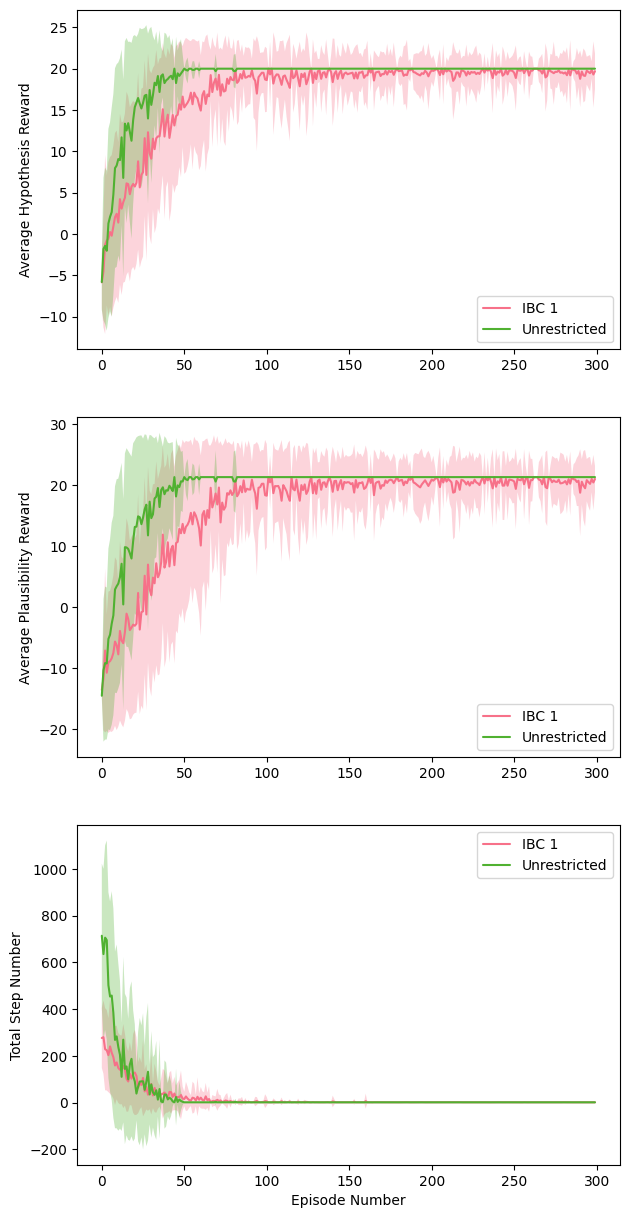

In [50]:
fig, ax = plt.subplots(3, 1, figsize=(7.0, 15.0))
ax[0].set_ylabel('Average Hypothesis Reward')
ax[1].set_ylabel('Average Plausibility Reward')
ax[2].set_xlabel('Episode Number')
ax[2].set_ylabel('Total Step Number')
colors = sns.color_palette("husl", 3)
plot_cut = 300
plot_cut1 = 0
with sns.axes_style("darkgrid"):
    for i in range(num_agents):
        xvals = np.arange(len(hypo_means[i]))[plot_cut1:plot_cut]
        hypo_means_cut = hypo_means[i][plot_cut1:plot_cut]
        hypo_stds_cut = hypo_stds[i][plot_cut1:plot_cut]
        plaus_means_cut = plaus_means[i][plot_cut1:plot_cut]
        plaus_stds_cut = plaus_stds[i][plot_cut1:plot_cut]
        stepnum_means_cut = stepnum_means[i][plot_cut1:plot_cut]
        stepnum_stds_cut = stepnum_stds[i][plot_cut1:plot_cut]
        hypo_means_cut1 = hypo_means1[plot_cut1:plot_cut]
        hypo_stds_cut1 = hypo_stds1[plot_cut1:plot_cut]
        plaus_means_cut1 = plaus_means1[plot_cut1:plot_cut]
        plaus_stds_cut1 = plaus_stds1[plot_cut1:plot_cut]
        stepnum_means_cut1 = stepnum_means1[plot_cut1:plot_cut]
        stepnum_stds_cut1 = stepnum_stds1[plot_cut1:plot_cut]
        ax[0].plot(xvals, hypo_means_cut, label='IBC {a0}'.format(a0=i+1), c=colors[0]) 
        ax[0].fill_between(xvals, y1=hypo_means_cut-hypo_stds_cut, y2=hypo_means_cut+hypo_stds_cut ,alpha=0.3, facecolor=colors[0])
        ax[1].plot(xvals, plaus_means_cut, label='IBC {a0}'.format(a0=i+1), c=colors[0]) 
        ax[1].fill_between(xvals, y1=plaus_means_cut-plaus_stds_cut, y2=plaus_means_cut+plaus_stds_cut ,alpha=0.3, facecolor=colors[0])
        ax[2].plot(xvals, stepnum_means_cut, label='IBC {a0}'.format(a0=i+1), c=colors[0]) 
        ax[2].fill_between(xvals, y1=stepnum_means_cut-stepnum_stds_cut, y2=stepnum_means_cut+stepnum_stds_cut ,alpha=0.3, facecolor=colors[0])
        ax[0].plot(xvals, hypo_means_cut1, label='Unrestricted', c=colors[1]) 
        ax[0].fill_between(xvals, y1=hypo_means_cut1-hypo_stds_cut1, y2=hypo_means_cut1+hypo_stds_cut1 ,alpha=0.3, facecolor=colors[1])
        ax[1].plot(xvals, plaus_means_cut1, label='Unrestricted', c=colors[1]) 
        ax[1].fill_between(xvals, y1=plaus_means_cut1-plaus_stds_cut1, y2=plaus_means_cut1+plaus_stds_cut1 ,alpha=0.3, facecolor=colors[1])
        ax[2].plot(xvals, stepnum_means_cut1, label='Unrestricted', c=colors[1]) 
        ax[2].fill_between(xvals, y1=stepnum_means_cut1-stepnum_stds_cut1, y2=stepnum_means_cut1+stepnum_stds_cut1 ,alpha=0.3, facecolor=colors[1])
 
ax[0].legend(loc='lower right') 
ax[1].legend(loc='lower right')
ax[2].legend() 
plt.savefig("./BrokenComp_InductiveBias_Training.png")
plt.show()

Each curve is an average over 50 agents each having different random number generator seeds. The fluctuations are quite large near the beginning because some agents find the right solution early on by chance, while others may take more time to find it. 

The agent with inductive bias configuration $\{2, [2, 2], [2, 2]\}$ (IBC 1) does reach very close to the optimal reward due to their ECM being just the right size to accommodate all scenarios. Note that as more agents are included in the ensemble, it is expected that the oscillations near the optimal reward will settle down and convergence will be attained.

The total step numbers up to 200 episodes are also calculated for the inductive bias and unrestricted agents, respectively.

In [48]:
print(sum(stepnum_means[0][: 200]), sum(stepnum_means1[: 200]))

5473.8800000000065 8167.560000000002
